In [1]:
# Note that this code must be run from python3 or ipython3 in a session's 
# terminal, not run directly in the graphical console. See
# https://github.com/dask/dask/issues/4612

import cdsw_dask_utils
import cdsw
import numpy as np
import pandas as pd

In [2]:
# #1. Load the data (From File )
input_file = "data/WineNewGBTDataSet.csv"
col_Names=["fixedAcidity",
    "volatileAcidity",
    "citricAcid",
    "residualSugar",
    "chlorides",
    "freeSulfurDioxide",
    "totalSulfurDioxide",
    "density",
    "pH",
    "sulphates",
    "Alcohol",
    "Quality"]


wine_df = pd.read_csv(input_file,sep=";",header=None, names=col_Names)
wine_df.head()

,fixedAcidity,volatileAcidity,citricAcid,residualSugar,chlorides,freeSulfurDioxide,totalSulfurDioxide,density,pH,sulphates,Alcohol,Quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,Poor
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,Poor
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,Poor
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,Excellent
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,Poor


In [3]:
# #### Cleanup - Remove invalid data
wine_df.Quality.replace('1',"Excellent",inplace=True)

# ### encode labels 
wine_df.Quality = pd.Categorical(wine_df.Quality)
wine_df['Label'] = wine_df.Quality.cat.codes
wine_df.head()


,fixedAcidity,volatileAcidity,citricAcid,residualSugar,chlorides,freeSulfurDioxide,totalSulfurDioxide,density,pH,sulphates,Alcohol,Quality,Label
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,Poor,1
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,Poor,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,Poor,1
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,Excellent,0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,Poor,1


In [4]:
# # 2. Build a classification model using MLLib
# ### Split Test/Train
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(wine_df.iloc[:,:11],
                                                    wine_df['Label'], 
                                                    test_size=0.2, 
                                                    random_state=30)



In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# ### parameters for grid search
param_numTrees = list(range(10,50,5))
param_maxDepth = list(range(4,16,2))

rfc = RandomForestClassifier(random_state=10, n_jobs=-1)

GS_params = { 
    'n_estimators': param_numTrees,
    'max_depth' : param_maxDepth
}

CV_rfc = GridSearchCV(estimator=rfc, 
                      param_grid=GS_params, 
                      cv= 3,
                      verbose = 1,
                      n_jobs=-1)

In [6]:
CV_rfc.fit(X_train, y_train)
# ### Show Best Parameters 
print(CV_rfc.best_params_)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.5s


{'max_depth': 12, 'n_estimators': 35}


[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:    7.1s finished


#### Evaluate model performance

In [7]:
from sklearn.metrics import classification_report
# ## fit test dataset 
y_true, y_pred = y_test, CV_rfc.predict(X_test)
# ## Print classification metrics 
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.88      0.83       170
           1       0.84      0.75      0.79       150

    accuracy                           0.82       320
   macro avg       0.82      0.81      0.81       320
weighted avg       0.82      0.82      0.81       320



<IPython.core.display.Javascript object>


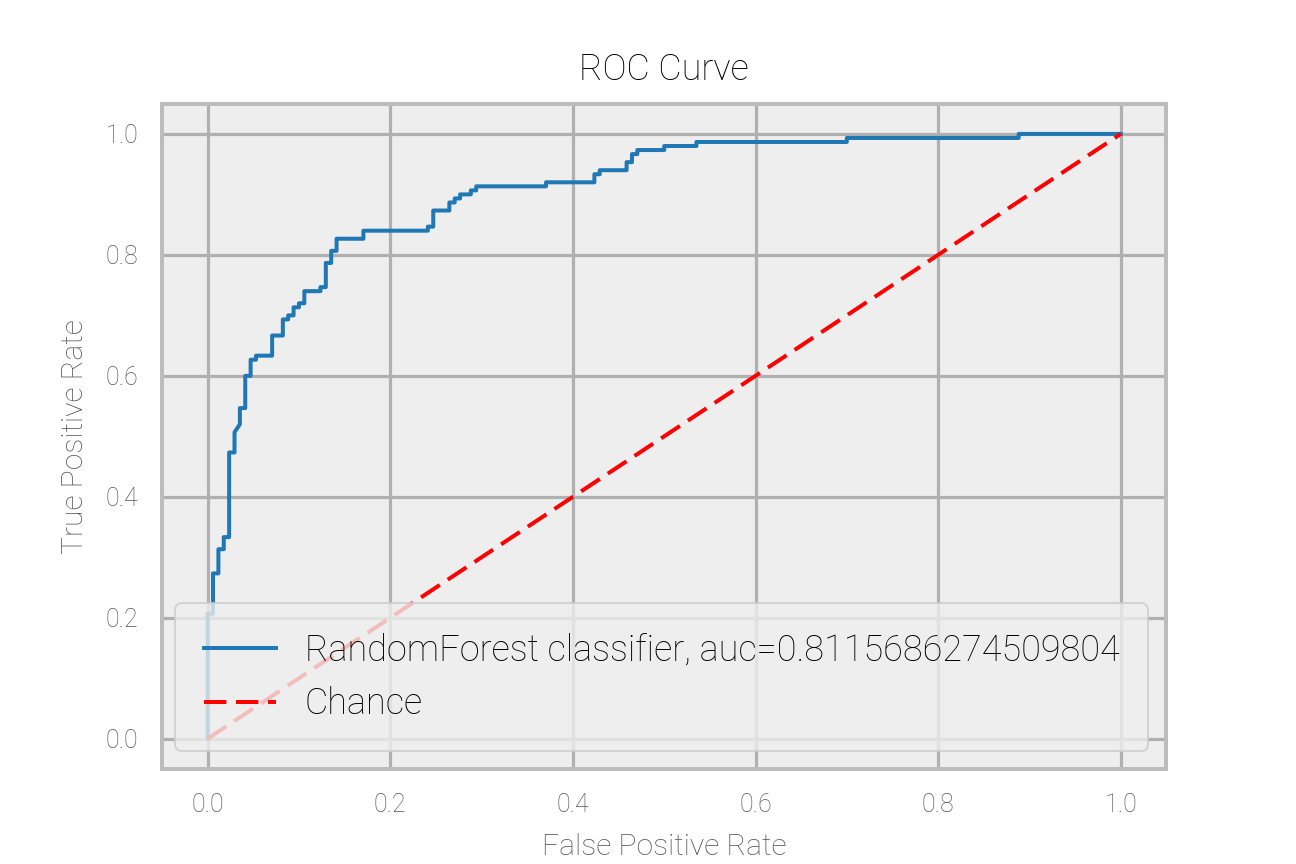

In [13]:
# ## Show ROC Curve 
# Calcultate points for ROC Curve
from sklearn.metrics import roc_curve,roc_auc_score

# get Area Under ROC curve metrics
y_pred_proba = CV_rfc.predict_proba(X_test)[:,1] 
auc = roc_auc_score(y_true, y_pred)

# get False Positive Rate and True Positive Rate  
fpr, tpr, _ = roc_curve(y_true, y_pred_proba)

#Plot ROC Curve
%matplotlib notebook
import matplotlib.pyplot as plt

plt.plot(fpr,tpr,label="RandomForest classifier, auc="+str(auc))
plt.plot([0, 1], [0, 1], linestyle='--',color='r',label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")

plt.show()

In [9]:
# Run a Dask cluster with three workers and return an object containing
# a description of the cluster. 
# 
# Using helper library 
#
# Note that the scheduler will run in the current session, and the Dask
# dashboard will become available in the nine-dot menu at the upper
# right corner of the CDSW app.

cluster = cdsw_dask_utils.run_dask_cluster(
  n=2, \
  cpu=1, \
  memory=2, \
  nvidia_gpu=0
)

Waiting for Dask scheduler to become ready...
Dask scheduler is ready
IDs ['lpk9rrjlkq3fg94g', 'zk1zovzhxjif78n7']


In [14]:
#Get the Dask Scheduler UI
import os 
engine_id = os.environ.get('CDSW_ENGINE_ID')
cdsw_domain = os.environ.get('CDSW_DOMAIN')

from IPython.core.display import HTML
HTML('<a  target="_blank" rel="noopener noreferrer" href="http://read-only-{}.{}">http://read-only-{}.{}</a>'
     .format(engine_id,cdsw_domain,engine_id,cdsw_domain))

In [15]:
# #### Connect a Dask client to the scheduler address in the cluster

from dask.distributed import Client
client = Client(cluster["scheduler_address"])

In [16]:
# ### Fit Model with Dask
from joblib import Parallel, parallel_backend
with parallel_backend('dask'):
  CV_rfc.fit(X_train, y_train)

# ### Show Best Parameters 
print(CV_rfc.best_params_)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend DaskDistributedBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:   37.1s finished


{'max_depth': 12, 'n_estimators': 35}


#### Evaluate model performance 

In [17]:
from sklearn.metrics import classification_report
# ## fit test dataset 
y_true, y_pred = y_test, CV_rfc.predict(X_test)
# ## Print classification metrics 
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.88      0.83       170
           1       0.84      0.75      0.79       150

    accuracy                           0.82       320
   macro avg       0.82      0.81      0.81       320
weighted avg       0.82      0.82      0.81       320



<IPython.core.display.Javascript object>


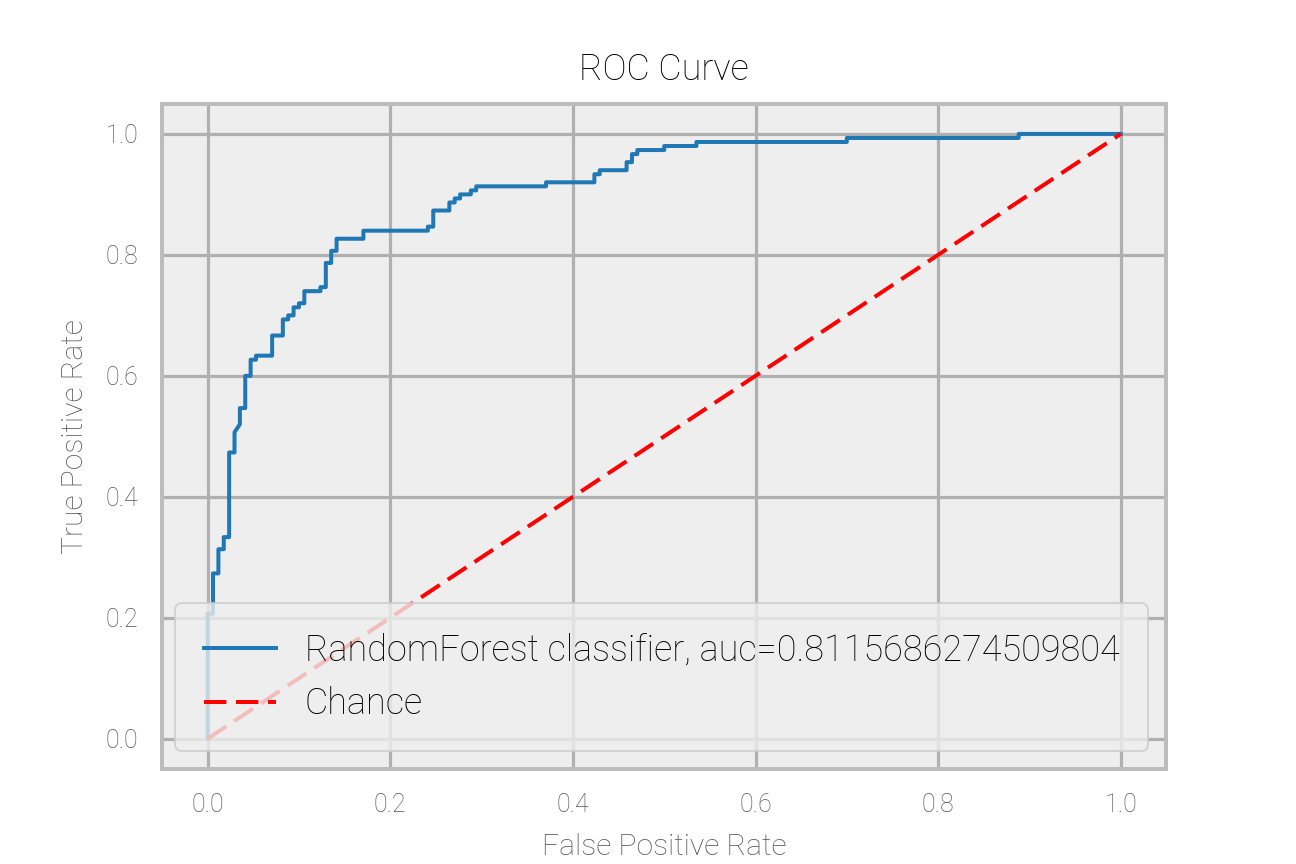

In [18]:
# ## Show ROC Curve 
# Calcultate points for ROC Curve
from sklearn.metrics import roc_curve,roc_auc_score

# get Area Under ROC curve metrics
y_pred_proba = CV_rfc.predict_proba(X_test)[:,1] 
auc = roc_auc_score(y_true, y_pred)

# get False Positive Rate and True Positive Rate  
fpr, tpr, _ = roc_curve(y_true, y_pred_proba)

#Plot ROC Curve
%matplotlib notebook
import matplotlib.pyplot as plt

plt.plot(fpr,tpr,label="RandomForest classifier, auc="+str(auc))
plt.plot([0, 1], [0, 1], linestyle='--',color='r',label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")

plt.show()

### Stop CDSW Workers

In [ ]:
## stop CDSW workers
import cdsw
cdsw.stop_workers()